# Analysis

Let's benchmark against all tool usage tasks. 

Expand the models list to benchmark with different models.

In [1]:
import datetime

from langsmith.client import Client

from langchain_benchmarks import (
    __version__,
    clone_public_dataset,
    model_registry,
    registry,
)
from langchain_benchmarks.rate_limiting import RateLimiter
from langchain_benchmarks.tool_usage.agents import (
    AnthropicToolUserFactory,
    CustomAgentFactory,
    OpenAIAgentFactory,
    OpenAIAssistantFactory,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from langsmith.client import Client

In [2]:
from datetime import datetime
client = Client()

In [26]:
experiment_ids = ["woof"]


def _endswith(s, suffixes):
    return any(s.endswith(suffix) for suffix in suffixes)


client = Client()
projects = [
    project
    for project in client.list_projects()
    if _endswith(project.name, experiment_ids)
]

print("\n".join(sorted([project.name for project in projects])))

claude-2.1-anthropic_tool_user-Multiverse Math-2023-12-18-woof
claude-2.1-anthropic_tool_user-Tool Usage - Relational Data-2023-12-18-woof
claude-2.1-anthropic_tool_user-Tool Usage - Typewriter (1 tool)-2023-12-18-woof
claude-2.1-anthropic_tool_user-Tool Usage - Typewriter (26 tools)-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Multiverse Math-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Tool Usage - Relational Data-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Tool Usage - Typewriter (1 tool)-2023-12-18-woof
gpt-3.5-turbo-0613-openai_functions-Tool Usage - Typewriter (26 tools)-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Multiverse Math-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Tool Usage - Relational Data-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Tool Usage - Typewriter (1 tool)-2023-12-18-woof
gpt-3.5-turbo-1106-openai_assistant-Tool Usage - Typewriter (26 tools)-2023-12-18-woof
gpt-3.5-turbo-1106-openai_functions-Multiverse Math-2023-

In [8]:
dfs = []
for project in projects:
    # Temporary way to get tag information
    project_info = client.read_project(project_id=project.id)
    
    if project_info.extra is None:
        raise ValueError(project.name)
    try:
        test_results = client.get_test_results(project_name=project.name)
    except Exception:
        continue

    for k, v in project_info.extra["metadata"].items():
        test_results[k] = v

    dfs.append(test_results)


df = pd.concat(dfs)

Compute a standardized "correct" column. It uses "Correct Final State" for tool usage tasks, and "correctness (which is based on output) for the other tasks.

In [9]:
correct = []

for r in df.to_dict(orient="records"):
    if "Typewriter" in r["task"]:
        correct.append(r["feedback.Correct Final State"])
    else:
        correct.append(r["feedback.correctness"])

df["correct"] = correct
df["correct"].fillna(0, inplace=True)

Compute some statistics. We're using estimating standard error of the mean assuming a bernoulli process.

In [21]:
num_correct = df.groupby(["model", 'arch', "task"])["correct"].sum().to_frame("num_correct")
total = df.groupby(["task", 'arch', "model"]).size().to_frame("total")
stats_df = total.join(num_correct)
stats_df["% correct"] = stats_df["num_correct"] / stats_df["total"]
stats_df["error"] = np.sqrt(
    stats_df["% correct"] * (1 - stats_df["% correct"]) / stats_df["total"]
)

# stats_df

models = [
     'mistral-7b-instruct-v0.1',
     'claude-2.1',
     'gpt-3.5-turbo-0613 (functions)',
     'gpt-3.5-turbo-1106 (assistant)',
     'gpt-3.5-turbo-1106 (functions)',
     'gpt-4-0613 (functions)',
     'gpt-4-1106-preview (assistant)',
     'gpt-4-1106-preview (functions)'
]

tasks = [
    "Tool Usage - Typewriter (1 tool)",
    "Tool Usage - Typewriter (26 tools)",
    "Multiverse Math",
    "Tool Usage - Relational Data",
]

stats_df = stats_df.reset_index()

In [22]:
names = []
for r in stats_df.to_dict(orient='records'):
    if r['model'].startswith('gpt'):
        if r['arch'] == "openai_assistant":
            names.append(f"{r['model']} (assistant)")
        else:
            names.append(f"{r['model']} (functions)")
    else:
        names.append(r['model'])
    

In [23]:
stats_df['model'] = names

In [24]:
# models = stats_df.set_index('task').loc['Tool Usage - Relational Data'].sort_values('% correct')['model'].to_list()

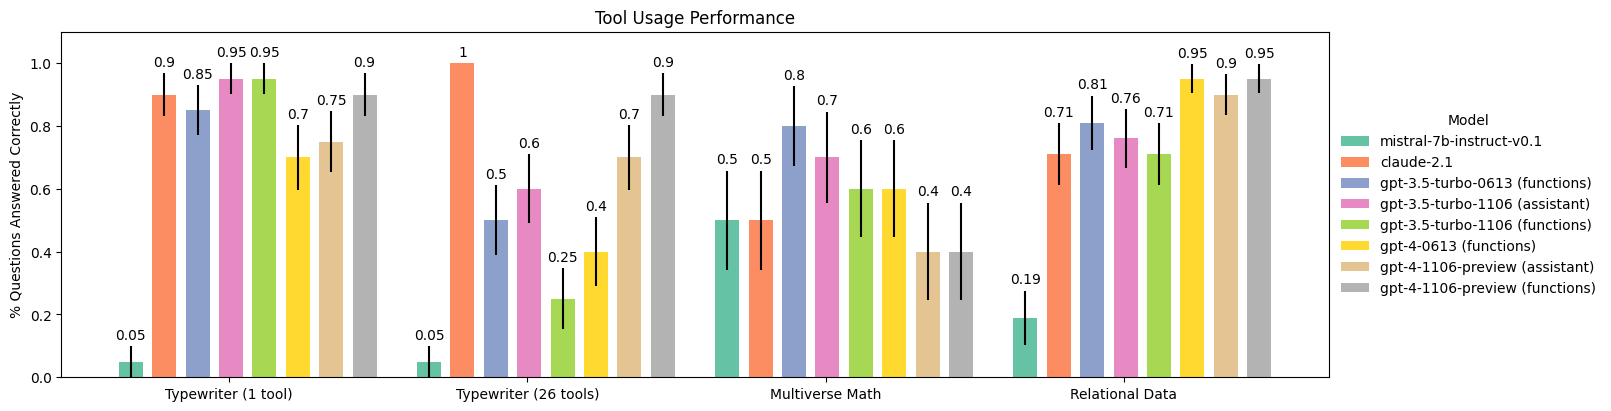

In [25]:
x = np.arange(len(tasks))  # the label locations
width = 0.08  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(16, 4))
colormap = plt.get_cmap("Set2").colors

for idx, model in enumerate(models):
    try:
        results = stats_df.set_index("model").loc[model]
    except:
        continue

    color = colormap[idx]
    
    
    errors = []
    values = []
    for task in tasks:
        try:
            result = results.set_index("task").loc[task]
            values.append(round(result['% correct'], 2))
            errors.append(result['error'])
        except KeyError:
            values.append(np.nan)
            errors.append(np.nan)
        

    offset = width * multiplier * 1.4
    rects = ax.bar(
        x + offset, values, width, label=model, yerr=errors, color=color
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("% Questions Answered Correctly")
ax.set_title("Tool Usage Performance")

labels = [
    task.removeprefix('Tool Usage - ')
    for task in tasks
]

ax.set_xticks(x + width + 0.25, labels)
ax.legend(
    loc="center left", ncols=1, bbox_to_anchor=(1.0, 0.5), frameon=False, title="Model"
)
ax.set_ylim(0, 1.10)

plt.show()